# *FORECASTING* CON REDES LSTM - MODELO MULTIVARIADO - UNISTEP Y MULTISTEP

## Contenido

1. [Introducción](#introduccion)
2. [El set de datos](#setdatos)
3. [El problema a resolver](#problema)
4. [Lectura del set de datos](#lectura)
5. [Procesamiento inicial del dataset](#)
6. [Análisis exploratorio](#)
7. [Pre-procesamiento](#)
8. [Conclusión](#)

## 1. Introducción <a id='introduccion'></a>

Primero se deben recopilar y preparar los datos. El siguiente paso sería entrenar el modelo utilizando técnicas de aprendizaje profundo y optimización para mejorar la precisión de las predicciones. Este modelo se puede utilizar para predecir valores futuros en una sola etapa (unistep), o para hacer predicciones en múltiples etapas futuras (multistep).

La implementación de un modelo LSTM multivariado unistep y multistep puede proporcionar una herramienta poderosa para la toma de decisiones basadas en datos precisos y procesables en una variedad de contextos comerciales y de investigación.

La idea es predecir el tiempo de viaje una hora a futuro (de ahí el término unistep) o bien de dos a mas horas (multistep) usando como entrada al modelo los registros historicos tales como el dia de la semana, paradero inicial, paradero destino, el tiempo de viaje (de ahí el término multivariado).

## 2. El set de datos <a id='setdatos'></a>

Se usa el dataset de los registros de GPS de la empresa Leon de San Jeronimo, un set de datos que contiene el registro histórico de 14 diferentes variables en el período de marzo 2023.

Se realizó e análisis exploratorio del dataset y su pre-procesamiento:

1. Hicimos el manejo de datos faltantes
2. Verificamos que el dataset no tuviese valores extremos (outliers)
3. Re-interpolamos el dataset para garantizar una periodicidad de 1 hora

## 3. El problema a resolver <a id='problema'></a>

Crear y entrenar una Red LSTM usando el enfoque univariado + single-step:

## 4. Lectura del set de datos <a id='lectura'></a>

In [1]:
import keras
import matplotlib
import subprocess
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.python.platform import build_info as build

In [2]:
print("Tensorflow".ljust(25) + f":{tf.__version__}")
print("Keras".ljust(25) + f":{keras.__version__}")
print("GPU Available".ljust(25) + f":{len(tf.config.experimental.list_physical_devices('GPU'))}")
print("Cuda Built".ljust(25) + f":{tf.test.is_built_with_cuda()}")
print("Cuda Version".ljust(25) + f":{build.build_info['cuda_version'].split('_')[1][:2]}" +"."+ f"{build.build_info['cuda_version'].split('_')[1][2:]}")
print("Cudnn Version".ljust(25) + f":{build.build_info['cudnn_version'].split('_')[1]}")
print("List Tensorflow GPUs".ljust(25) + f":{tf.config.list_physical_devices('GPU')}")
print("Name of GPU".ljust(25) + f":{subprocess.check_output('nvidia-smi --query-gpu=gpu_name --format=csv', shell=True).decode().splitlines()[1]}")
print("Numpy Version".ljust(25) + f":{np.__version__}")
print("Pandas Version".ljust(25) + f":{pd.__version__}")
print("Matplotlib Version".ljust(25) + f":{matplotlib.__version__}")

Tensorflow               :2.10.1
Keras                    :2.10.0
GPU Available            :1
Cuda Built               :True
Cuda Version             :11.2
Cudnn Version            :8
List Tensorflow GPUs     :[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Name of GPU              :NVIDIA GeForce RTX 3070 Ti Laptop GPU
Numpy Version            :1.22.3
Pandas Version           :1.5.3
Matplotlib Version       :3.7.1


Se selecciona ciertas columnas que se consideran relevantes para preparar las secuencias posteriormente

- "id_sample": es un identificador único para cada muestra en la tabla.
- "init_stop": representa la parada inicial en la ruta.
- "end_stop": representa la parada final en la ruta.
- "linkref": es un identificador único para cada enlace de referencia en la ruta.
- "date_time_init": es la fecha y hora en que se inició el recorrido en la ruta.
- "date_time_end": es la fecha y hora en que se finalizó el recorrido en la ruta.
- "time_travel": representa la duración del viaje entre la parada inicial y la parada final.

In [12]:
data = pd.read_csv('../data/samples_without_nan.csv', usecols=['id_sample','init_stop', 'end_stop', 'linkref', 'date_time_init', 'date_time_end', 'time_travel'])
data['date_time_init'] = pd.to_datetime(data['date_time_init'])
data['date_time_end'] = pd.to_datetime(data['date_time_end'])
data['DayOfWeek'] = data['date_time_init'].dt.weekday
#data.set_index('date_time_init', inplace= True)
data

,id_sample,init_stop,end_stop,linkref,date_time_init,date_time_end,time_travel,DayOfWeek
0,0,0,36,0:36,2023-03-01 07:24:22,2023-03-01 07:27:33,191.0,2
1,0,36,37,36:37,2023-03-01 07:27:33,2023-03-01 07:29:19,106.0,2
2,0,37,38,37:38,2023-03-01 07:29:19,2023-03-01 07:30:49,90.0,2
3,0,38,39,38:39,2023-03-01 07:30:49,2023-03-01 07:31:13,24.0,2
4,0,39,40,39:40,2023-03-01 07:31:13,2023-03-01 07:32:29,76.0,2
...,...,...,...,...,...,...,...,...
212392,2559,113,114,113:114,2023-03-25 07:51:20,2023-03-25 07:51:32,12.0,5
212393,2559,114,115,114:115,2023-03-25 07:51:32,2023-03-25 07:53:02,90.0,5
212394,2559,115,116,115:116,2023-03-25 07:53:02,2023-03-25 07:53:14,12.0,5
212395,2559,116,117,116:117,2023-03-25 07:53:14,2023-03-25 07:53:26,12.0,5


Imprimir si existen NAN en el dataset

In [4]:
print('Cantidad de NaNs:')
for column in data:
    nans = data[column].isna().sum()
    print(f'\tColumna {column}: {nans}')

Cantidad de NaNs:
	Columna id_sample: 0
	Columna init_stop: 0
	Columna end_stop: 0
	Columna linkref: 0
	Columna date_time_init: 0
	Columna date_time_end: 0
	Columna time_travel: 0
	Columna DayOfWeek: 0


Mostrar los 15 datos con viaje de paradero a paradero mas duraderos

In [5]:
max_x=data.nlargest(15, ['time_travel'])
max_x

,id_sample,init_stop,end_stop,linkref,date_time_init,date_time_end,time_travel,DayOfWeek
51543,621,0,36,0:36,2023-03-06 09:57:29,2023-03-06 10:30:40,1991.0,0
10541,127,0,36,0:36,2023-03-01 14:04:39,2023-03-01 14:37:49,1990.0,2
67811,817,0,36,0:36,2023-03-08 13:13:37,2023-03-08 13:43:28,1791.0,2
15355,185,0,36,0:36,2023-03-02 09:16:27,2023-03-02 09:44:59,1712.0,3
156040,1881,0,36,0:36,2023-03-19 06:57:27,2023-03-19 07:25:01,1654.0,6
830,10,0,36,0:36,2023-03-01 14:02:10,2023-03-01 14:29:17,1627.0,2
108066,1303,0,36,0:36,2023-03-13 09:48:29,2023-03-13 10:14:56,1587.0,0
17845,215,0,36,0:36,2023-03-02 14:18:57,2023-03-02 14:44:37,1540.0,3
81091,977,0,36,0:36,2023-03-10 09:13:27,2023-03-10 09:38:50,1523.0,4
60839,733,0,36,0:36,2023-03-07 09:20:49,2023-03-07 09:45:42,1493.0,1


Mostrar los 15 datos con viaje de paradero a paradero menos duraderos

In [6]:
min_x=data.nsmallest(15, ['time_travel'])
min_x

,id_sample,init_stop,end_stop,linkref,date_time_init,date_time_end,time_travel,DayOfWeek
198553,2393,52,53,52:53,2023-03-23 05:18:22,2023-03-23 05:18:25,3.0,3
609,7,63,64,63:64,2023-03-01 05:10:58,2023-03-01 05:11:02,4.0,2
22316,268,107,108,107:108,2023-03-03 19:26:10,2023-03-03 19:26:14,4.0,4
108249,1305,52,53,52:53,2023-03-13 07:02:07,2023-03-13 07:02:11,4.0,0
128833,1553,52,53,52:53,2023-03-16 05:03:05,2023-03-16 05:03:09,4.0,3
131240,1582,52,53,52:53,2023-03-16 09:35:56,2023-03-16 09:36:00,4.0,3
149638,1803,107,108,107:108,2023-03-18 10:01:34,2023-03-18 10:01:38,4.0,5
181383,2186,63,64,63:64,2023-03-22 05:03:02,2023-03-22 05:03:06,4.0,2
207766,2504,52,53,52:53,2023-03-24 04:52:31,2023-03-24 04:52:35,4.0,4
211584,2550,52,53,52:53,2023-03-25 05:31:30,2023-03-25 05:31:34,4.0,5


Observacion de los datos del time_travel

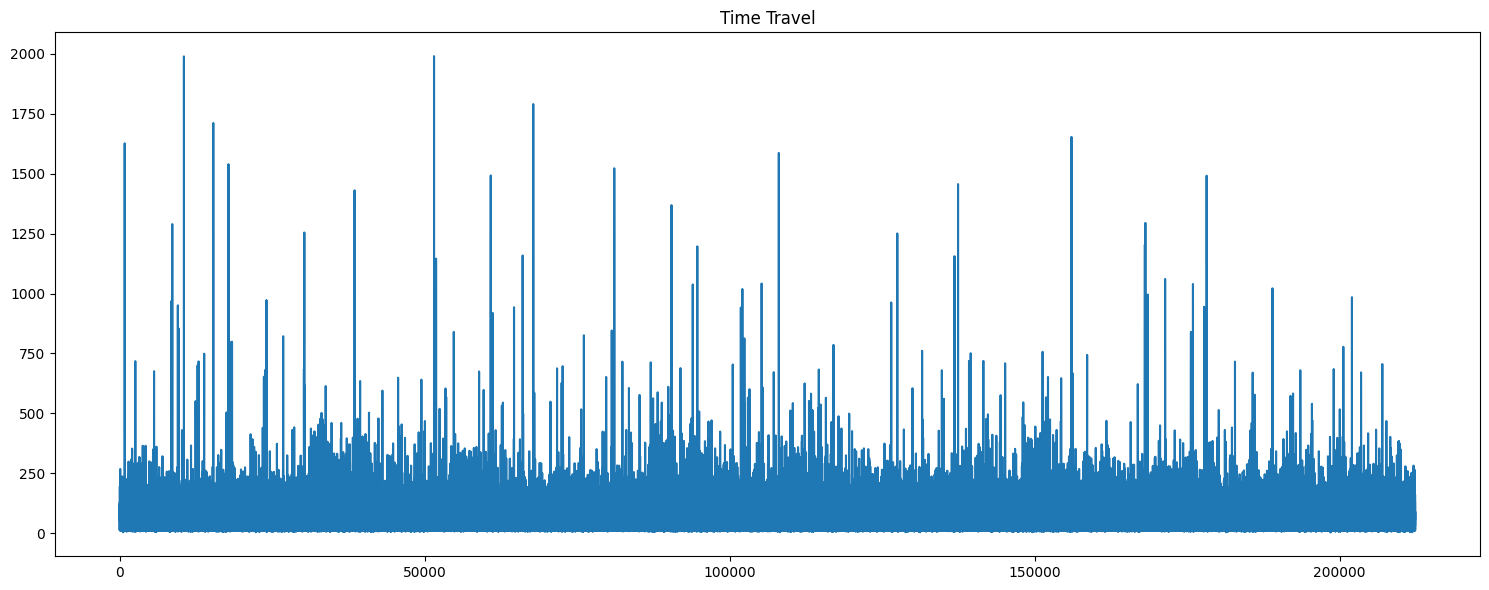

In [7]:
plt.figure(figsize=(15, 6))
data['time_travel'].plot()
plt.ylabel(None)
plt.xlabel(None)
plt.title("Time Travel")
plt.tight_layout()
plt.show()

Observacion de las columnas del dataset

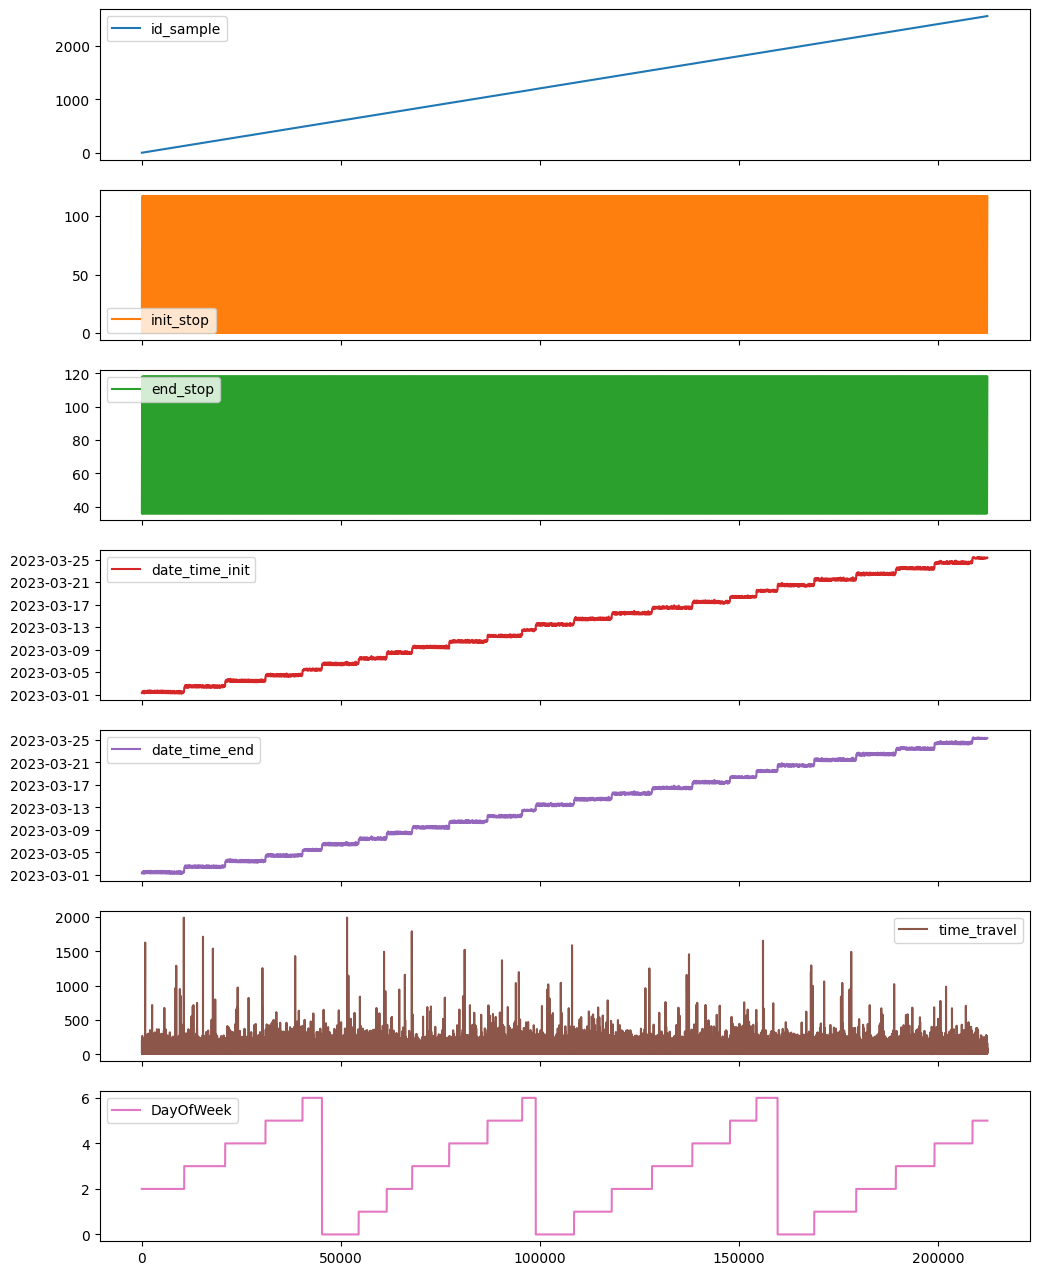

In [8]:
cols = data.columns

# Dibujar la totalidad de registros
N = data.shape[0]       # Número de registros
plots = data[cols][0:N] # Series de tiempo individuales
plots.index = data.index[0:N] # Variable tiempo
_ = plots.plot(subplots=True, figsize=(12,16))


Ajuste de periodicidad, en estas pruebas se considera hacer fracciones de tiempo cada 1 minuto

In [13]:
#Crear una columna que sera indice de periodicidad
ix = pd.DatetimeIndex(pd.to_datetime(data['date_time_init'])).floor('1min')#.floor('10S')#.floor('0.1min')
data["datetime"] = ix

#Crear indice datetime
data.set_index('datetime', inplace= True)
data

,id_sample,init_stop,end_stop,linkref,date_time_init,date_time_end,time_travel,DayOfWeek
datetime,,,,,,,,
2023-03-01 07:20:00,0,0,36,0:36,2023-03-01 07:24:22,2023-03-01 07:27:33,191.0,2
2023-03-01 07:25:00,0,36,37,36:37,2023-03-01 07:27:33,2023-03-01 07:29:19,106.0,2
2023-03-01 07:25:00,0,37,38,37:38,2023-03-01 07:29:19,2023-03-01 07:30:49,90.0,2
2023-03-01 07:30:00,0,38,39,38:39,2023-03-01 07:30:49,2023-03-01 07:31:13,24.0,2
2023-03-01 07:30:00,0,39,40,39:40,2023-03-01 07:31:13,2023-03-01 07:32:29,76.0,2
...,...,...,...,...,...,...,...,...
2023-03-25 07:50:00,2559,113,114,113:114,2023-03-25 07:51:20,2023-03-25 07:51:32,12.0,5
2023-03-25 07:50:00,2559,114,115,114:115,2023-03-25 07:51:32,2023-03-25 07:53:02,90.0,5
2023-03-25 07:50:00,2559,115,116,115:116,2023-03-25 07:53:02,2023-03-25 07:53:14,12.0,5


Elegir un sample y mostrar las diferencias de tiempo para observar los tiempos repetidos que son representados por los 0

In [93]:
#Se filtra un sample y se ejecuta el analisis
df_filtrado = data[data['id_sample'] == 0]
df_time_diffs = df_filtrado.index.to_series().diff().dt.total_seconds()
print(df_time_diffs.value_counts())

60.0     43
0.0      23
120.0    15
180.0     1
Name: datetime, dtype: int64


Elegir todos samples y mostrar las diferencias de tiempo para observar los tiempos repetidos que son representados por los 0

In [94]:
df_list = pd.DataFrame()
#Iterar los samples y concatenar
for value in data['id_sample'].unique():
    df_filtrado = data[data['id_sample'] == value]
    df_time_diffs = df_filtrado.index.to_series().diff().dt.total_seconds()
    df_list = pd.concat([df_list,df_time_diffs], axis=0)

print(df_list.value_counts())

60.0      109196
0.0        63647
120.0      26905
180.0       7280
240.0       1864
300.0        495
360.0        207
420.0         93
480.0         37
540.0         21
600.0         16
660.0         15
720.0         13
960.0          7
1020.0         7
780.0          6
840.0          5
1500.0         4
1140.0         3
1680.0         2
1560.0         2
1980.0         2
1320.0         2
1260.0         2
1200.0         2
1380.0         1
1440.0         1
1620.0         1
1800.0         1
900.0          1
dtype: int64


Guardar dataset procesado

In [95]:
data.to_csv('../data/dataset_v1.csv')

# Crear sets de entrenamiento, validación y prueba

Leer el dataset procesado anteriormente

In [91]:
df = pd.read_csv('../data/dataset_v1.csv', usecols=['datetime','linkref', 'time_travel'])
df.set_index('datetime', inplace= True)
df

,linkref,time_travel
datetime,,
2023-03-01 07:24:00,0:36,191.0
2023-03-01 07:27:00,36:37,106.0
2023-03-01 07:29:00,37:38,90.0
2023-03-01 07:30:00,38:39,24.0
2023-03-01 07:31:00,39:40,76.0
...,...,...
2023-03-25 07:51:00,113:114,12.0
2023-03-25 07:51:00,114:115,90.0
2023-03-25 07:53:00,115:116,12.0


In [92]:
# Supongamos que tienes una columna llamada 'columna' en tu DataFrame 'datos'
columna_strings = df['linkref']

# Obtén la lista única de valores en la columna
valores_unicos = columna_strings.unique()

# Ordena los valores únicos
#valores_unicos_ordenados = sorted(valores_unicos)

# Crea un diccionario para mapear los valores únicos a la codificación numérica
diccionario_codificacion = {valor: indice for indice, valor in enumerate(valores_unicos)}

# Aplica la codificación a la columna
df['links'] = columna_strings.map(diccionario_codificacion)

# Imprime los valores originales y los codificados
print("Valores originales:", df['links'].values)
print("Valores codificados:", df['links'].values)

first_column = df.pop('links')
df.insert(0, 'links', first_column)
df = pd.DataFrame(df.drop('linkref', axis=1))
df

Valores originales: [ 0  1  2 ... 80 81 82]
Valores codificados: [ 0  1  2 ... 80 81 82]


,links,time_travel
datetime,,
2023-03-01 07:24:00,0,191.0
2023-03-01 07:27:00,1,106.0
2023-03-01 07:29:00,2,90.0
2023-03-01 07:30:00,3,24.0
2023-03-01 07:31:00,4,76.0
...,...,...
2023-03-25 07:51:00,78,12.0
2023-03-25 07:51:00,79,90.0
2023-03-25 07:53:00,80,12.0


In [93]:
scaler_time_travel = MinMaxScaler()
scaler_links = MinMaxScaler()

df['time_travel'] = df['time_travel'].astype(float)  # Convertir a punto flotante
df['time_travel'] = scaler_time_travel.fit_transform(df['time_travel'].values.reshape(-1, 1))

df['links'] = df['links'].astype(float)  # Convertir a punto flotante
df['links'] = scaler_links.fit_transform(df['links'].values.reshape(-1, 1))

df

,links,time_travel
datetime,,
2023-03-01 07:24:00,0.000000,0.094567
2023-03-01 07:27:00,0.012195,0.051811
2023-03-01 07:29:00,0.024390,0.043763
2023-03-01 07:30:00,0.036585,0.010563
2023-03-01 07:31:00,0.048780,0.036720
...,...,...
2023-03-25 07:51:00,0.951220,0.004527
2023-03-25 07:51:00,0.963415,0.043763
2023-03-25 07:53:00,0.975610,0.004527


In [90]:
# Realizar la transformación inversa de 'time_travel'
df['time_travel2'] = scaler_time_travel.inverse_transform(df['time_travel'].values.reshape(-1, 1))

# Realizar la transformación inversa de 'links'
df['links2'] = scaler_links.inverse_transform(df['links'].values.reshape(-1, 1))

# Verificar el resultado
print(df)

                        links  time_travel  time_travel2  links2
datetime                                                        
2023-03-01 07:24:00  0.000000     0.094567         191.0     0.0
2023-03-01 07:27:00  0.012195     0.051811         106.0     1.0
2023-03-01 07:29:00  0.024390     0.043763          90.0     2.0
2023-03-01 07:30:00  0.036585     0.010563          24.0     3.0
2023-03-01 07:31:00  0.048780     0.036720          76.0     4.0
...                       ...          ...           ...     ...
2023-03-25 07:51:00  0.951220     0.004527          12.0    78.0
2023-03-25 07:51:00  0.963415     0.043763          90.0    79.0
2023-03-25 07:53:00  0.975610     0.004527          12.0    80.0
2023-03-25 07:53:00  0.987805     0.004527          12.0    81.0
2023-03-25 07:53:00  1.000000     0.016600          36.0    82.0

[212397 rows x 4 columns]


In [94]:
def train_val_test_split(serie, tr_size=0.8, vl_size=0.1, ts_size=0.1 ):
    # Definir número de datos en cada subserie
    N = serie.shape[0]
    Ntrain = int(tr_size*N)  # Número de datos de entrenamiento
    Nval = int(vl_size*N)    # Número de datos de validación
    Ntst = N - Ntrain - Nval # Número de datos de prueba

    # Realizar partición
    train = serie[0:Ntrain]
    val = serie[Ntrain:Ntrain+Nval]
    test = serie[Ntrain+Nval:]

    return train, val, test

Se dispondra que del total de samples:
  - 80% seran para entrenamiento
  - 10% para validación 
  - 10% para test

In [95]:
tr_size=0.8
vl_size=0.1 
ts_size=0.1

tr, vl, ts = train_val_test_split(df)

# Imprimir en pantalla el tamaño de cada subset
print(f'Tamaño total de datos      ({100}%):  {df.shape[0]}')
print(f'Tamaño set de entrenamiento ({int(tr_size*100)}%):  {tr.shape}')
print(f'Tamaño set de validación    ({int(vl_size*100)}%):  {vl.shape}')
print(f'Tamaño set de prueba        ({int(ts_size*100)}%):  {ts.shape}')

Tamaño total de datos      (100%):  212397
Tamaño set de entrenamiento (80%):  (169917, 2)
Tamaño set de validación    (10%):  (21239, 2)
Tamaño set de prueba        (10%):  (21241, 2)


Mostrar los datos que se han dividido

In [ ]:
# covar = 1 # Índice de la covariable (columna del dataset) a graficar
# col = df.columns[covar]

# # Dibujar los sets de entrenamiento/validación/prueba para la covariable
# fig, ax = plt.subplots(figsize = (16,5))
# ax.plot(tr[col], label='Train')
# ax.plot(vl[col], label='Val')
# ax.plot(ts[col], label='Test')
# ax.set_title(f'Covariable: {col}')
# plt.legend();

Generar los datasets normalizados y organizar secuencias

In [96]:
X, Y = [], []

In [97]:
def crear_dataset_supervisado(array, input_length, output_length):
    '''Permite crear un dataset con las entradas (X) y salidas (Y)
    requeridas por la Red LSTM.

    Parámetros:
    - array: arreglo numpy de tamaño N x features (N: cantidad de datos, f: cantidad de features)
    - input_length: instantes de tiempo consecutivos de la(s) serie(s) de tiempo usados para alimentar el modelo
    - output_length: instantes de tiempo a pronosticar (salida del modelo)
    '''

    # Inicialización
    X, Y = [], []    # Listados que contendrán los datos de entrada y salida del modelo
    shape = array.shape
    if len(shape)==1: # Si tenemos sólo una serie (univariado)
        fils, cols = array.shape[0], 1
        array = array.reshape(fils,cols)
    else: # Multivariado
        fils, cols = array.shape

    # Generar los arreglos
    for i in range(fils-input_length-output_length):
        X.append(array[i:i+input_length,0:cols])
        Y.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))
    
    # Convertir listas a arreglos de NumPy
    X = np.array(X)
    Y = np.array(Y)
    
    return X, Y

In [98]:
# Crear los datasets de entrenamiento, prueba y validación y verificar sus tamaños
INPUT_LENGTH = 83    # Posteriormente afinaremos este hiperparámetro
OUTPUT_LENGTH = 1    # Modelo uni-step

x_tr, y_tr = crear_dataset_supervisado(tr.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_vl, y_vl = crear_dataset_supervisado(vl.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_ts, y_ts = crear_dataset_supervisado(ts.values, INPUT_LENGTH, OUTPUT_LENGTH)

# Imprimir información en pantalla
print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (169833, 83, 2), y_tr: (169833, 1, 1)
Set de validación - x_vl: (21155, 83, 2), y_vl: (21155, 1, 1)
Set de prueba - x_ts: (21157, 83, 2), y_ts: (21157, 1, 1)


In [99]:
from sklearn.preprocessing import MinMaxScaler

def escalar_dataset(data_input, col_ref):
    '''Escala el dataset en el rango de -1 a 1.

    Entradas:
    - data_input: diccionario con los dataset de entrada y salida del modelo
    (data_input = {'x_tr':x_tr, 'y_tr':y_tr, 'x_vl':x_vl, 'y_vl':y_vl,
                    'y_ts':y_ts})
    - col_ref: parámetro adicional para especificar la columna que contiene
      la variable a predecir

    
    Retorna:
    - data_scaled: diccionario con los datasets de entrada y salida escalados
      (tiene la misma estructura del diccionario de entrada)
    - scaler: el escalador usado (requerido para las predicciones)
    '''

    # *** Implementación adicional: determinar el índice de la columna
    # que contiene la variable a predecir
    col_ref = df.columns.get_loc(col_ref)

    # Número de instantes de tiempo de entrada y de covariables
    NFEATS = data_input['x_tr'].shape[2]

    # Generar listado con "scalers" (1 por cada covariable de entrada)
    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]

    # Arreglos que contendrán los datasets escalados
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    # Escalamiento: se usarán los min/max del set de entrenamiento para
    # escalar la totalidad de los datasets

    # Escalamiento Xs
    for i in range(NFEATS):
        x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i])
        x_vl_s[:,:,i] = scalers[i].transform(x_vl[:,:,i])
        x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])
    
    # Escalamiento Ys (teniendo en cuenta "col_ind")
    y_tr_s[:,:,0] = scalers[col_ref].fit_transform(y_tr[:,:,0])
    y_vl_s[:,:,0] = scalers[col_ref].transform(y_vl[:,:,0])
    y_ts_s[:,:,0] = scalers[col_ref].transform(y_ts[:,:,0])

    # Conformar diccionario de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scalers[col_ref]

In [100]:
# Escalamiento del dataset con la función anterior

# Crear diccionario de entrada
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
}

# Y escalar
data_s, scaler = escalar_dataset(data_in, col_ref = 'time_travel')

# Extraer subsets escalados
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

# Verificación
print(f'Min x_tr/x_vl/x_ts sin escalamiento: {x_tr.min()}/{x_vl.min()}/{x_ts.min()}')
print(f'Min x_tr/x_vl/x_ts con escalamiento: {x_tr_s.min()}/{x_vl_s.min()}/{x_ts_s.min()}')

print(f'\nMin y_tr/y_vl/y_ts sin escalamiento: {y_tr.min()}/{y_vl.min()}/{y_ts.min()}')
print(f'Min y_tr/y_vl/y_ts con escalamiento: {y_tr_s.min()}/{y_vl_s.min()}/{y_ts_s.min()}')

print(f'\nMax x_tr/x_vl/x_ts sin escalamiento: {x_tr.max()}/{x_vl.max()}/{x_ts.max()}')
print(f'Max x_tr/x_vl/x_ts con escalamiento: {x_tr_s.max()}/{x_vl_s.max()}/{x_ts_s.max()}')

print(f'\nMax y_tr/y_vl/y_ts sin escalamiento: {y_tr.max()}/{y_vl.max()}/{y_ts.max()}')
print(f'Max y_tr/y_vl/y_ts con escalamiento: {y_tr_s.max()}/{y_vl_s.max()}/{y_ts_s.max()}')

Min x_tr/x_vl/x_ts sin escalamiento: 0.0/0.0/0.0
Min x_tr/x_vl/x_ts con escalamiento: -1.0/-1.0/-1.0010065425264218

Min y_tr/y_vl/y_ts sin escalamiento: 0.0005030181086519115/0.0005030181086519115/0.0
Min y_tr/y_vl/y_ts con escalamiento: -1.0/-1.0/-1.0010065425264218

Max x_tr/x_vl/x_ts sin escalamiento: 1.0/1.0/1.0
Max x_tr/x_vl/x_ts con escalamiento: 1.0/1.0/1.0

Max y_tr/y_vl/y_ts sin escalamiento: 1.0/0.7489939637826962/0.49396378269617713
Max y_tr/y_vl/y_ts con escalamiento: 1.0/0.49773527931555117/-0.012581781580271678


In [ ]:
# Y generemos una gráfica tipo violín para ver la distribución
# de los valores en cada covariable (entrada) y en la variable a
# predecir (salida)

fig, ax = plt.subplots(figsize=(12,4))
for i in range(2):
    ax.violinplot(dataset=x_tr_s[:,:,i].flatten(), positions=[i])
    ax.violinplot(dataset=x_vl_s[:,:,i].flatten(), positions=[i])
    ax.violinplot(dataset=x_ts_s[:,:,i].flatten(), positions=[i])

# Etiquetas eje horizontal
ax.set_xticks(list(range(13)))
ax.set_xticklabels(df.keys(), rotation=90)
ax.autoscale();

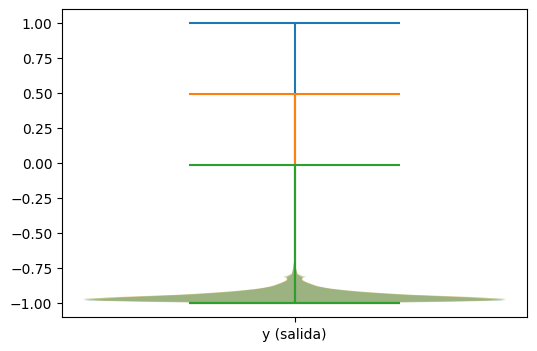

In [80]:
# Y hagamos lo mismo con la variable de salida:
fig, ax = plt.subplots(figsize=(6,4))
ax.violinplot(dataset=y_tr_s.flatten())
ax.violinplot(dataset=y_vl_s.flatten())
ax.violinplot(dataset=y_ts_s.flatten())
ax.set_xticks([1])
ax.set_xticklabels(['y (salida)']);

In [104]:
# Creación del modelo
from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import CuDNNLSTM, Dense
from keras.layers import CuDNNLSTM, Dense
from tensorflow.keras.optimizers import RMSprop, Adam
import tensorflow as tf

# Ajustar parámetros para reproducibilidad del entrenamiento
tf.random.set_seed(123)
tf.config.experimental.enable_op_determinism()

# El modelo
N_UNITS = 128 # Tamaño del estado oculto (h) y de la celdad de memoria (c) (128)
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2]) # 24 (horas) x 13 (features)

modelo = Sequential()
modelo.add(CuDNNLSTM(N_UNITS, input_shape=INPUT_SHAPE))

# Y lo único que cambia con respecto al modelo multivariado + uni-step es
# el tamaño deldato de salida
modelo.add(Dense(OUTPUT_LENGTH, activation='linear')) # activation = 'linear' pues queremos pronosticar (regresión)

# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades de la temperatura
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

# Compilación
optimizador = RMSprop(learning_rate=5e-4) # 5e-5
modelo.compile(
    optimizer = optimizador,
    loss = root_mean_squared_error,
)

# Entrenamiento (aproximadamente 1 min usando GPU)
EPOCHS = 80 # Hiperparámetro
BATCH_SIZE = 256 # Hiperparámetro
historia = modelo.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s),
    verbose=2
)

Epoch 1/80
664/664 - 16s - loss: 0.0638 - val_loss: 0.0453 - 16s/epoch - 24ms/step
Epoch 2/80
664/664 - 15s - loss: 0.0486 - val_loss: 0.0533 - 15s/epoch - 22ms/step
Epoch 3/80
664/664 - 15s - loss: 0.0457 - val_loss: 0.0436 - 15s/epoch - 22ms/step
Epoch 4/80
664/664 - 15s - loss: 0.0437 - val_loss: 0.0420 - 15s/epoch - 22ms/step
Epoch 5/80
664/664 - 15s - loss: 0.0409 - val_loss: 0.0505 - 15s/epoch - 22ms/step
Epoch 6/80
664/664 - 15s - loss: 0.0396 - val_loss: 0.0427 - 15s/epoch - 22ms/step
Epoch 7/80
664/664 - 15s - loss: 0.0391 - val_loss: 0.0391 - 15s/epoch - 23ms/step
Epoch 8/80
664/664 - 15s - loss: 0.0387 - val_loss: 0.0423 - 15s/epoch - 23ms/step
Epoch 9/80
664/664 - 15s - loss: 0.0383 - val_loss: 0.0374 - 15s/epoch - 23ms/step
Epoch 10/80
664/664 - 15s - loss: 0.0380 - val_loss: 0.0383 - 15s/epoch - 23ms/step
Epoch 11/80
664/664 - 15s - loss: 0.0378 - val_loss: 0.0385 - 15s/epoch - 23ms/step
Epoch 12/80
664/664 - 15s - loss: 0.0375 - val_loss: 0.0389 - 15s/epoch - 23ms/step
E

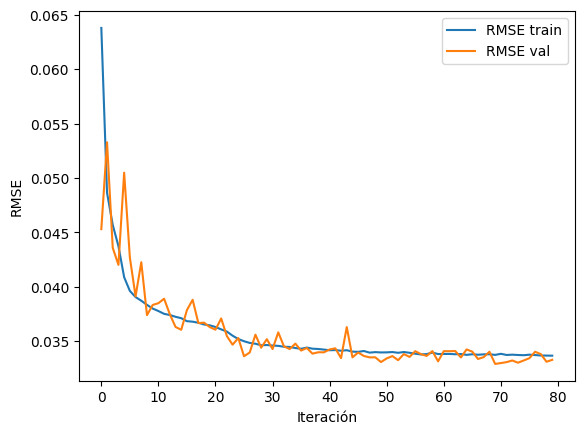

In [105]:
 # Graficar curvas de entrenamiento y validación
 # para verificar que no existe overfitting
plt.plot(historia.history['loss'],label='RMSE train')
plt.plot(historia.history['val_loss'],label='RMSE val')
plt.xlabel('Iteración')
plt.ylabel('RMSE')
plt.legend();

In [106]:
# Cálculo de rmses para train, val y test
rmse_tr = modelo.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_vl = modelo.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
rmse_ts = modelo.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)

# Imprimir resultados en pantalla
print('Comparativo desempeños:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE val:\t {rmse_vl:.3f}')
print(f'  RMSE test:\t {rmse_ts:.3f}')

Comparativo desempeños:
  RMSE train:	 0.030
  RMSE val:	 0.030
  RMSE test:	 0.029


In [107]:
def predecir(x, model, scaler):
    '''Genera la predicción de OUTPUT_LENGTH instantes
    de tiempo a futuro con el modelo entrenado.

    Entrada:
    - x: batch (o batches) de datos para ingresar al modelo
      (tamaño: BATCHES X INPUT_LENGTH X FEATURES)
    - model: Red LSTM entrenada
    - scaler: escalador (requerido para llevar la predicción a la escala original)
    
    Salida:
    - y_pred: la predicción en la escala original (tamaño: BATCHES X OUTPUT_LENGTH X FEATURES)
    '''

    # Calcular predicción escalada en el rango de -1 a 1
    y_pred_s = model.predict(x,verbose=0)

    # Llevar la predicción a la escala original
    y_pred = scaler.inverse_transform(y_pred_s)

    return y_pred.flatten()

In [108]:
# Calcular predicciones sobre el set de prueba
y_ts_pred = predecir(x_ts_s, modelo, scaler)

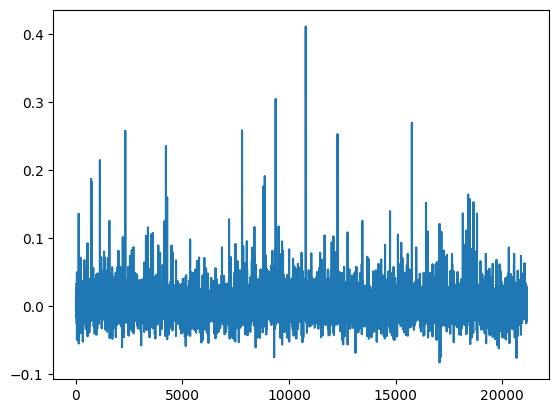

In [109]:
N = len(y_ts_pred)    # Número de predicciones
ndato = np.linspace(1,N,N)

# Cálculo de errores simples
errores = y_ts.flatten()-y_ts_pred
plt.plot(errores);

# FIN PRUEBAS

In [ ]:
# Escalamiento del dataset con la función anterior

# Crear diccionario de entrada
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
}

# Y escalar (especificando la columna con la variable a predecir)
data_s, scaler = escalar_dataset(data_in, col_ref = 'time_travel' )

# Extraer subsets escalados
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

In [ ]:
# Creación del modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf

# Ajustar parámetros para reproducibilidad del entrenamiento
tf.random.set_seed(123)
tf.config.experimental.enable_op_determinism()

# El modelo
N_UNITS = 128 # Tamaño del estado oculto (h) y de la celda de memoria (c)
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2]) # 24 (horas) x 1 (feature)

modelo = Sequential()
modelo.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))
modelo.add(Dense(OUTPUT_LENGTH, activation='linear')) # activation = 'linear' pues queremos pronosticar (regresión)

# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades de la temperatura
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

# Compilación
optimizador = RMSprop(learning_rate=5e-5)
modelo.compile(
    optimizer = optimizador,
    loss = root_mean_squared_error,
)

# Entrenamiento (aproximadamente 1 min usando GPU)
EPOCHS = 80 # Hiperparámetro
BATCH_SIZE = 256 # Hiperparámetro
historia = modelo.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s),
    verbose=2
)

Crear frecuencias de tiempo cada 15 minutos

In [107]:
data.reset_index(inplace=True)
ix = pd.DatetimeIndex(pd.to_datetime(data['date_time_init'])).floor('15min')
data["DateTimeRef"] = ix
data["DowTimeRef"] = pd.to_datetime((data['DayOfWeek'].values - 1) * 24 * 60 * 60 + ix.hour * 60 * 60 + ix.minute * 60, unit = 's')
data

,date_time_init,init_stop,end_stop,linkref,date_time_end,time_travel,DayOfWeek,DateTimeRef,DowTimeRef
0,2023-03-01 07:25:51,0,36,0:36,2023-03-01 07:27:33,102.0,2,2023-03-01 07:15:00,1970-01-02 07:15:00
1,2023-03-01 07:27:33,36,37,36:37,2023-03-01 07:29:19,106.0,2,2023-03-01 07:15:00,1970-01-02 07:15:00
2,2023-03-01 07:29:19,37,38,37:38,2023-03-01 07:30:49,90.0,2,2023-03-01 07:15:00,1970-01-02 07:15:00
3,2023-03-01 07:30:49,38,39,38:39,2023-03-01 07:31:13,24.0,2,2023-03-01 07:30:00,1970-01-02 07:30:00
4,2023-03-01 07:31:13,39,40,39:40,2023-03-01 07:32:29,76.0,2,2023-03-01 07:30:00,1970-01-02 07:30:00
...,...,...,...,...,...,...,...,...,...
212475,2023-03-25 07:51:20,113,114,113:114,2023-03-25 07:51:32,12.0,5,2023-03-25 07:45:00,1970-01-05 07:45:00
212476,2023-03-25 07:51:32,114,115,114:115,2023-03-25 07:53:02,90.0,5,2023-03-25 07:45:00,1970-01-05 07:45:00
212477,2023-03-25 07:53:02,115,116,115:116,2023-03-25 07:53:14,12.0,5,2023-03-25 07:45:00,1970-01-05 07:45:00
212478,2023-03-25 07:53:14,116,117,116:117,2023-03-25 07:53:26,12.0,5,2023-03-25 07:45:00,1970-01-05 07:45:00


In [108]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212480 entries, 0 to 212479
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date_time_init  212480 non-null  datetime64[ns]
 1   init_stop       212480 non-null  int64         
 2   end_stop        212480 non-null  int64         
 3   linkref         212480 non-null  object        
 4   date_time_end   212480 non-null  datetime64[ns]
 5   time_travel     212480 non-null  float64       
 6   DayOfWeek       212480 non-null  int64         
 7   DateTimeRef     212480 non-null  datetime64[ns]
 8   DowTimeRef      212480 non-null  datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(3), object(1)
memory usage: 14.6+ MB


Filtrar datos por paradero

In [109]:
data_filtrado = data[data['linkref'] == '0:36']
data_filtrado

,date_time_init,init_stop,end_stop,linkref,date_time_end,time_travel,DayOfWeek,DateTimeRef,DowTimeRef
0,2023-03-01 07:25:51,0,36,0:36,2023-03-01 07:27:33,102.0,2,2023-03-01 07:15:00,1970-01-02 07:15:00
83,2023-03-01 10:34:33,0,36,0:36,2023-03-01 10:35:55,82.0,2,2023-03-01 10:30:00,1970-01-02 10:30:00
166,2023-03-01 14:02:05,0,36,0:36,2023-03-01 14:04:13,128.0,2,2023-03-01 14:00:00,1970-01-02 14:00:00
249,2023-03-01 06:37:35,0,36,0:36,2023-03-01 06:39:17,102.0,2,2023-03-01 06:30:00,1970-01-02 06:30:00
332,2023-03-01 09:31:18,0,36,0:36,2023-03-01 09:32:15,57.0,2,2023-03-01 09:30:00,1970-01-02 09:30:00
...,...,...,...,...,...,...,...,...,...
212065,2023-03-25 07:07:53,0,36,0:36,2023-03-25 07:09:13,80.0,5,2023-03-25 07:00:00,1970-01-05 07:00:00
212148,2023-03-25 06:16:20,0,36,0:36,2023-03-25 06:18:02,102.0,5,2023-03-25 06:15:00,1970-01-05 06:15:00
212231,2023-03-25 06:21:51,0,36,0:36,2023-03-25 06:23:33,102.0,5,2023-03-25 06:15:00,1970-01-05 06:15:00
212314,2023-03-25 07:01:28,0,36,0:36,2023-03-25 07:03:10,102.0,5,2023-03-25 07:00:00,1970-01-05 07:00:00


In [110]:
bootstrap_size_pct = 0.75
test_window_pct = 0.05
n = len(data)
i=1

# Devide into test and train
data_train = data[:int((bootstrap_size_pct + i * test_window_pct) * n)]
data_test = data[int((bootstrap_size_pct + i * test_window_pct) * n):int((bootstrap_size_pct + (i + 1) * test_window_pct) * n)]

In [111]:
data_train

,date_time_init,init_stop,end_stop,linkref,date_time_end,time_travel,DayOfWeek,DateTimeRef,DowTimeRef
0,2023-03-01 07:25:51,0,36,0:36,2023-03-01 07:27:33,102.0,2,2023-03-01 07:15:00,1970-01-02 07:15:00
1,2023-03-01 07:27:33,36,37,36:37,2023-03-01 07:29:19,106.0,2,2023-03-01 07:15:00,1970-01-02 07:15:00
2,2023-03-01 07:29:19,37,38,37:38,2023-03-01 07:30:49,90.0,2,2023-03-01 07:15:00,1970-01-02 07:15:00
3,2023-03-01 07:30:49,38,39,38:39,2023-03-01 07:31:13,24.0,2,2023-03-01 07:30:00,1970-01-02 07:30:00
4,2023-03-01 07:31:13,39,40,39:40,2023-03-01 07:32:29,76.0,2,2023-03-01 07:30:00,1970-01-02 07:30:00
...,...,...,...,...,...,...,...,...,...
169979,2023-03-21 13:24:03,113,114,113:114,2023-03-21 13:24:16,13.0,1,2023-03-21 13:15:00,1970-01-01 13:15:00
169980,2023-03-21 13:24:16,114,115,114:115,2023-03-21 13:25:03,47.0,1,2023-03-21 13:15:00,1970-01-01 13:15:00
169981,2023-03-21 13:25:03,115,116,115:116,2023-03-21 13:25:22,19.0,1,2023-03-21 13:15:00,1970-01-01 13:15:00
169982,2023-03-21 13:25:22,116,117,116:117,2023-03-21 13:25:35,13.0,1,2023-03-21 13:15:00,1970-01-01 13:15:00


In [112]:
data_test

,date_time_init,init_stop,end_stop,linkref,date_time_end,time_travel,DayOfWeek,DateTimeRef,DowTimeRef
169984,2023-03-21 15:16:13,0,36,0:36,2023-03-21 15:17:55,102.0,1,2023-03-21 15:15:00,1970-01-01 15:15:00
169985,2023-03-21 15:17:55,36,37,36:37,2023-03-21 15:19:26,91.0,1,2023-03-21 15:15:00,1970-01-01 15:15:00
169986,2023-03-21 15:19:26,37,38,37:38,2023-03-21 15:21:13,107.0,1,2023-03-21 15:15:00,1970-01-01 15:15:00
169987,2023-03-21 15:21:13,38,39,38:39,2023-03-21 15:21:59,46.0,1,2023-03-21 15:15:00,1970-01-01 15:15:00
169988,2023-03-21 15:21:59,39,40,39:40,2023-03-21 15:23:04,65.0,1,2023-03-21 15:15:00,1970-01-01 15:15:00
...,...,...,...,...,...,...,...,...,...
180603,2023-03-22 15:09:30,113,114,113:114,2023-03-22 15:09:40,10.0,2,2023-03-22 15:00:00,1970-01-02 15:00:00
180604,2023-03-22 15:09:40,114,115,114:115,2023-03-22 15:10:16,36.0,2,2023-03-22 15:00:00,1970-01-02 15:00:00
180605,2023-03-22 15:10:16,115,116,115:116,2023-03-22 15:10:52,36.0,2,2023-03-22 15:00:00,1970-01-02 15:00:00
180606,2023-03-22 15:10:52,116,117,116:117,2023-03-22 15:11:04,12.0,2,2023-03-22 15:00:00,1970-01-02 15:00:00


In [114]:
import datetime
def info(msg):
    print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S') + " " + msg)

n_train = len(data_train)
n_test = len(data_test)
info('- Train size : {:>8} ({:.2f}%) '.format(n_train, 1. * n_train / n))
info('- Test size  : {:>8} ({:.2f}%) '.format(n_test, 1. * n_test / n))

2023-04-17 16:02:51 - Train size :   169984 (0.80%) 
2023-04-17 16:02:51 - Test size  :    10624 (0.05%) 


# Pruebas con un modelo LSTM

In [115]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import CuDNNLSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# leer el archivo csv
data = pd.read_csv('samples_1v.csv', usecols=['init_stop', 'end_stop', 'linkref', 'date_time_init', 'date_time_end', 'time_travel'])

# convertir la columna date_time_init a datetime
data['date_time_init'] = pd.to_datetime(data['date_time_init'])

# agrupar los datos por enlace y hora de salida para obtener una secuencia de tiempo
grouped_data = data.groupby(['linkref', pd.Grouper(key='date_time_init', freq='H')])['time_travel'].mean().reset_index()

# dividir los datos en entrenamiento y prueba
train_size = int(len(grouped_data) * 0.8)
train_data, test_data = grouped_data[:train_size], grouped_data[train_size:]

# normalizar los datos de entrada
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_norm = scaler.fit_transform(train_data[['time_travel']])
test_data_norm = scaler.transform(test_data[['time_travel']])

# función para crear secuencias de tiempo
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length-1):
        X.append(data[i:(i+seq_length)])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# crear secuencias de tiempo para los datos de entrenamiento y prueba
seq_length = 24
X_train, y_train = create_sequences(train_data_norm, seq_length)
X_test, y_test = create_sequences(test_data_norm, seq_length)

# construir el modelo LSTM
model = Sequential()
model.add(CuDNNLSTM(64, input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# entrenar el modelo
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# hacer predicciones para los datos de prueba
y_pred = model.predict(X_test)


Epoch 1/50
675/675 [==============================] - 9s 6ms/step - loss: 8.4706e-04 - val_loss: 5.6862e-04
Epoch 2/50
675/675 [==============================] - 4s 6ms/step - loss: 7.1055e-05 - val_loss: 5.4156e-04
Epoch 3/50
675/675 [==============================] - 4s 6ms/step - loss: 7.1314e-05 - val_loss: 5.4550e-04
Epoch 4/50
675/675 [==============================] - 4s 6ms/step - loss: 7.3620e-05 - val_loss: 5.6109e-04
Epoch 5/50
675/675 [==============================] - 4s 6ms/step - loss: 7.2972e-05 - val_loss: 5.6008e-04
Epoch 6/50
675/675 [==============================] - 4s 6ms/step - loss: 7.1149e-05 - val_loss: 5.3361e-04
Epoch 7/50
675/675 [==============================] - 4s 6ms/step - loss: 7.6613e-05 - val_loss: 5.5283e-04
Epoch 8/50
675/675 [==============================] - 4s 6ms/step - loss: 7.4783e-05 - val_loss: 5.3918e-04
Epoch 9/50
675/675 [==============================] - 4s 6ms/step - loss: 7.1675e-05 - val_loss: 5.5424e-04
Epoch 10/50
675/675 [=======

In [39]:
len(X_train), len(y_train)

(21596, 21596)

In [40]:
len(X_test), len(y_test)

(5381, 5381)

In [21]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

Mean Squared Error: 0.0005314730609634774
Root Mean Squared Error: 0.02305369950709598


In [41]:
y_test

array([[0.35872024],
       [0.36338739],
       [0.36677339],
       ...,
       [0.36176789],
       [0.36427746],
       [0.36371261]])

In [38]:
# desnormalizar la salida
y_pred_desnormalized = scaler.inverse_transform(y_pred)

# imprimir la predicción
print(y_pred_desnormalized)

[[44.765656]
 [41.63561 ]
 [41.741196]
 ...
 [35.941006]
 [35.34355 ]
 [36.01339 ]]


In [31]:
# definir el momento de inicio del viaje
date_time_init = '2023-04-11 12:00:00'

# definir las paradas de origen y destino
init_stop = '0'
end_stop = '36'

# obtener los datos correspondientes a las paradas y el momento seleccionados
selected_data = data[(data['init_stop'] == init_stop) & (data['end_stop'] == end_stop) & (data['date_time_init'] >= date_time_init)]
selected_data = selected_data.head(seq_length)  # asegurarse de tener suficientes registros para construir una secuencia

# normalizar los datos
selected_data_norm = scaler.transform(selected_data[['time_travel']])

# crear la secuencia de tiempo
X_new, y_new = create_sequences(selected_data_norm, seq_length)

# hacer la predicción
y_pred_new = model.predict(X_new)

# desnormalizar la predicción
y_pred_new = scaler.inverse_transform(y_pred_new)

# imprimir la predicción
print('El tiempo de viaje estimado entre', init_stop, 'y', end_stop, 'a las', date_time_init, 'es:', y_pred_new[0][0], 'minutos.')

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by MinMaxScaler.

In [36]:
# Crear un nuevo conjunto de datos para hacer una predicción
new_data = pd.DataFrame({
    'init_stop': ['0'],
    'end_stop': ['36'],
    'date_time_init': ['2022-05-15 09:00:00']
})

# Convertir la columna date_time_init a datetime
new_data['date_time_init'] = pd.to_datetime(new_data['date_time_init'])

# Unir el nuevo conjunto de datos con el conjunto de datos original para obtener el linkref correspondiente
new_data = pd.merge(new_data, data[['init_stop', 'end_stop', 'date_time_init', 'linkref']], on=['init_stop', 'end_stop', 'date_time_init'], how='inner')

# Crear una secuencia de tiempo para el nuevo conjunto de datos
new_seq, _ = create_sequences(scaler.transform(new_data[['time_travel']]), seq_length)

# Hacer una predicción en el nuevo conjunto de datos normalizado
new_pred_norm = model.predict(new_seq)

# Desnormalizar la salida de la predicción
new_pred = scaler.inverse_transform(new_pred_norm)

# Mostrar la salida final de la predicción
print('La predicción de time_travel es:', new_pred[0][0])

KeyError: "None of [Index(['time_travel'], dtype='object')] are in the [columns]"

In [ ]:
import pandas as pd

# crear el DataFrame con el dato nuevo
new_data = pd.DataFrame({
    'init_stop': [36],
    'end_stop': [37],
    'date_time_init': ['2023-04-15 08:00:00'],
    'time_travel': [0.0],
    'init_idp': [None],
    'end_idp': [None],
    'veh': [None],
    'lap': [None],
    'date': [None]
})
# convertir la columna 'date_time_init' a datetime
new_data['date_time_init'] = pd.to_datetime(new_data['date_time_init'])

# extraer características de fecha y hora
new_data['year'] = new_data['date_time_init'].dt.year
new_data['month'] = new_data['date_time_init'].dt.month
new_data['day'] = new_data['date_time_init'].dt.day
new_data['hour'] = new_data['date_time_init'].dt.hour
new_data['minute'] = new_data['date_time_init'].dt.minute

# normalizar los datos numéricos
new_data[num_cols] = scaler.transform(new_data[num_cols])

In [ ]:
# obtener las características relevantes para la predicción
new_X = new_data[relevant_cols]

# convertir los datos a un tensor de numpy
new_X = np.array(new_X)

# ajustar la forma del tensor a la requerida por el modelo LSTM
new_X = new_X.reshape((1, new_X.shape[0], new_X.shape[1]))

# hacer la predicción
y_pred = model.predict(new_X)

# invertir la normalización de la predicción
y_pred_inv = scaler_y.inverse_transform(y_pred)

# imprimir el resultado de la predicción
print('La hora de llegada estimada al paradero 37 es:', y_pred_inv[0][0])

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, CuDNNLSTM
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# cargar los datos
data = pd.read_csv('samples_1v.csv', usecols=['init_stop', 'end_stop', 'linkref', 'time_travel'])

# separar la columna de tiempo de llegada como la variable objetivo
target_col = 'time_travel'
y = data[target_col].values

# eliminar las columnas de fecha y hora del conjunto de datos
data = data.drop(['date_time_init', 'date_time_end'], axis=1)

# eliminar las filas con valores faltantes
data = data.dropna()

# normalizar los datos de entrada
scaler = MinMaxScaler()
X = scaler.fit_transform(data.values)

# dividir el conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# definir el modelo LSTM
model = Sequential()
model.add(CuDNNLSTM(128, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))

# compilar el modelo
model.compile(loss='mean_squared_error', optimizer='adam')

# entrenar el modelo
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
history = model.fit(X_train.reshape((X_train.shape[0], X_train.shape[1], 1)), y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stop], verbose=1)

# hacer predicciones para los datos de prueba
y_pred = model.predict(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)))

# calcular las métricas de evaluación en el conjunto de prueba
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# imprimir las métricas de evaluación
print('r2 score: {:.4f}'.format(r2))
print('mse: {:.4f}'.format(mse))
print('mae: {:.4f}'.format(mae))

KeyError: "['date_time_init', 'date_time_end'] not found in axis"

# Pruebas 2 LSTM

Importar las librerías necesarias:

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, CuDNNLSTM, Dropout

Cargar los datos y convertir las fechas en formato datetime:

In [105]:
#Leer datos necesarios
data = pd.read_csv('samples_1v.csv', usecols=['init_stop', 'end_stop', 'linkref', 'date_time_init', 'date_time_end', 'time_travel'], parse_dates=['date_time_init', 'date_time_end'])
len(data)

212480

In [106]:
# Separar los datos en entrenamiento y prueba
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]
print('Datos de entrenamiento: ',len(train_data),'\nDatos de test: ',len(test_data),'\nTotal de datos: ',len(train_data)+len(test_data))

Datos de entrenamiento:  169984 
Datos de test:  42496 
Total de datos:  212480


Normalizar datos

In [107]:
# Normalizar los datos
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data[['init_stop', 'end_stop', 'time_travel']])
test_scaled = scaler.transform(test_data[['init_stop', 'end_stop', 'time_travel']])

Separar conjunto de datos (entrenamiento y prueba)

In [108]:
# Crear conjuntos de datos de entrenamiento y prueba
X_train = []
y_train = []
for i in range(60, len(train_scaled)):
    X_train.append(train_scaled[i-60:i, :])
    y_train.append(train_scaled[i, 2])
X_train, y_train = np.array(X_train), np.array(y_train)

X_test = []
y_test = []
for i in range(60, len(test_scaled)):
    X_test.append(test_scaled[i-60:i, :])
    y_test.append(test_scaled[i, 2])
X_test, y_test = np.array(X_test), np.array(y_test)

Crear modelo CuDNNLSTM

In [121]:
# Crear el modelo LSTM
model = Sequential()
model.add(CuDNNLSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(CuDNNLSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(CuDNNLSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

Entrenar modelo

In [118]:
# Entrenar el modelo
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
5311/5311 [==============================] - 40s 7ms/step - loss: 3.7693e-04 - val_loss: 9.1060e-06
Epoch 2/50
5311/5311 [==============================] - 38s 7ms/step - loss: 2.1775e-05 - val_loss: 8.6868e-06
Epoch 3/50
5311/5311 [==============================] - 37s 7ms/step - loss: 2.0682e-05 - val_loss: 1.0340e-05
Epoch 4/50
5311/5311 [==============================] - 38s 7ms/step - loss: 2.0114e-05 - val_loss: 8.5357e-06
Epoch 5/50
5311/5311 [==============================] - 36s 7ms/step - loss: 1.9700e-05 - val_loss: 8.7471e-06
Epoch 6/50
5311/5311 [==============================] - 37s 7ms/step - loss: 1.9235e-05 - val_loss: 8.5064e-06
Epoch 7/50
5311/5311 [==============================] - 37s 7ms/step - loss: 1.9100e-05 - val_loss: 8.9141e-06
Epoch 8/50
5311/5311 [==============================] - 37s 7ms/step - loss: 1.8872e-05 - val_loss: 8.6108e-06
Epoch 9/50
5311/5311 [==============================] - 37s 7ms/step - loss: 1.8811e-05 - val_loss: 8.5371e-06
E

In [103]:
from datetime import timedelta

# Convertir los tiempos predichos a segundos y luego a enteros
y_pred_sec = y_pred.astype(int)

# Crear una lista de objetos timedelta
y_pred_timedelta = [timedelta(seconds=int(x)) for x in y_pred_sec]

# Imprimir los primeros 10 valores
print(y_pred_timedelta[0])

0:00:54
